  # **Trabajo Práctico 3**

    Año: 2025
    Materia: Minería de Datos
    Integrantes: Juan Andres Morales, Genaro Canciani
    

# EDA

In [198]:
import os

# Análisis exploratorio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pylab as pl

# Preparación de los datos
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn import datasets
import optuna

# Clasificador SVM
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay ,classification_report,recall_score,precision_score)
import warnings
warnings.filterwarnings('ignore')

In [199]:
df = pd.read_csv('dxWeather.csv')
df.head()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Localizacion,TipoClima,Estacion
0,39,96,8.5,71,1011.43,Llanura,Nublado,Primavera
1,30,64,7.0,16,1018.72,Montania,Soleado,Primavera
2,38,83,1.5,82,1026.25,Costa,Soleado,Primavera
3,32,55,3.5,26,1010.03,Llanura,Nublado,Verano
4,3,85,6.0,96,984.46,Llanura,Nevado,Invierno


In [200]:
df.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000
mean,21.872349,67.195045,9.634936,50.796333,1007.685836
std,16.426722,20.463797,6.795890,32.333798,38.763971
min,-24.000000,20.000000,0.000000,0.000000,800.230000
25%,13.000000,55.000000,5.000000,18.000000,998.570000
50%,23.000000,69.000000,8.500000,53.000000,1010.315000
75%,32.000000,81.000000,13.500000,80.000000,1017.820000
max,109.000000,109.000000,47.500000,109.000000,1199.210000


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperatura         10090 non-null  int64  
 1   Humedad             10090 non-null  int64  
 2   VientoVelocidad     10090 non-null  float64
 3   Precipitation       10090 non-null  int64  
 4   PresionAtmosferica  10090 non-null  float64
 5   Localizacion        10090 non-null  object 
 6   TipoClima           10090 non-null  object 
 7   Estacion            10090 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 630.8+ KB


In [202]:
print(df.isna().sum()[df.isna().sum() > 0]) # no hay nulos

Series([], dtype: int64)


In [203]:
localizaciones_unicas = df.Localizacion.unique()
print(localizaciones_unicas)

climas_unicos = df.TipoClima.unique()
print(climas_unicos)

estaciones_unicas = df.Estacion.unique()
print(estaciones_unicas)

['Llanura' 'Montania' 'Costa']
['Nublado' 'Soleado' 'Nevado' 'Lluvioso']
['Primavera' 'Verano' 'Invierno' 'Otonio']


In [204]:
# Codificamos columnas categoricas
columnas = ['Localizacion', 'TipoClima']

enc = OneHotEncoder(sparse_output=False)
cols = enc.fit_transform(df[columnas])
enc_df = pd.DataFrame(cols, columns=enc.get_feature_names_out(['Localizacion', 'TipoClima']), index=df.index)
df_final = pd.concat([enc_df, df], axis=1).drop(columns=['Localizacion', 'TipoClima'],axis=1)


## split

In [205]:
# Separo variable objetivo de datos
X = df_final.drop('Estacion', axis=1)
y = df_final['Estacion']

In [206]:
# Obtengo datos de entrenamiento y de testeo
Xtrn, Xtst, ytrn, ytst  = train_test_split(X, y, test_size=0.2,
                            random_state=1234, shuffle=True, stratify=y)

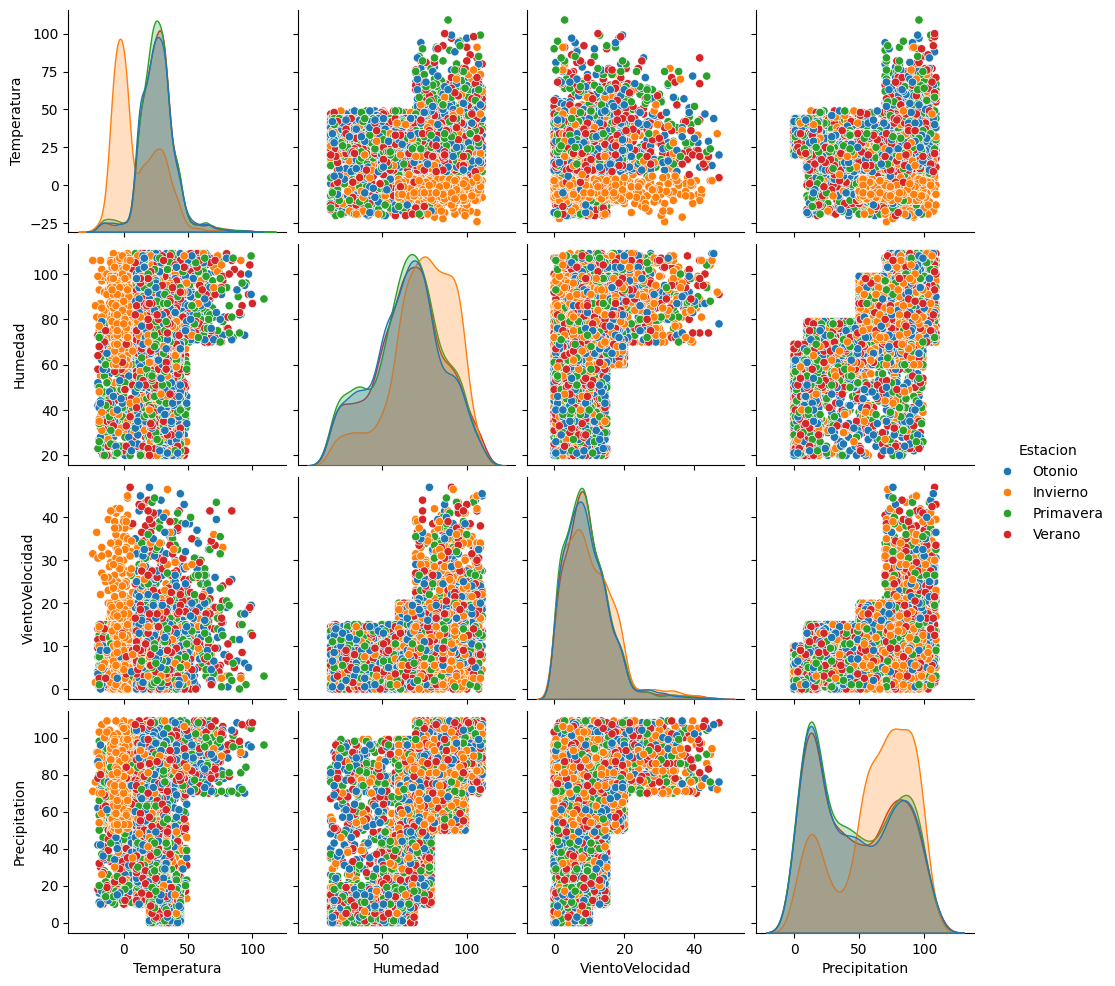

In [207]:
numerical_cols = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation']
sns.pairplot(pd.concat([Xtrn[numerical_cols], ytrn], axis=1), hue='Estacion')
plt.show()

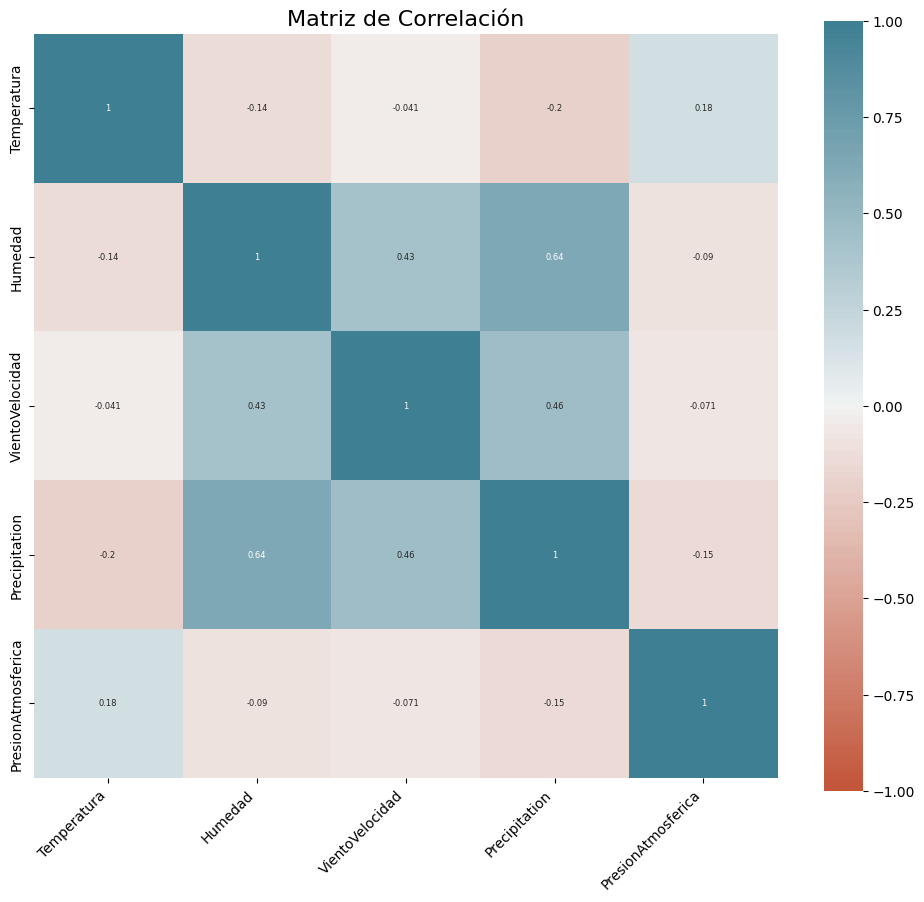

In [208]:
num_cols = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']
plt.figure(figsize=(12, 10))
corr = Xtrn[num_cols].corr(method='pearson')
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

Se observa en el gráfico de arriba en general algunas correlaciones fuertes como el caso de humedad con precipitación. Sin embargo algunas correlaciones son considerablemente bajas como la de la velocidad del viento con la presión. 

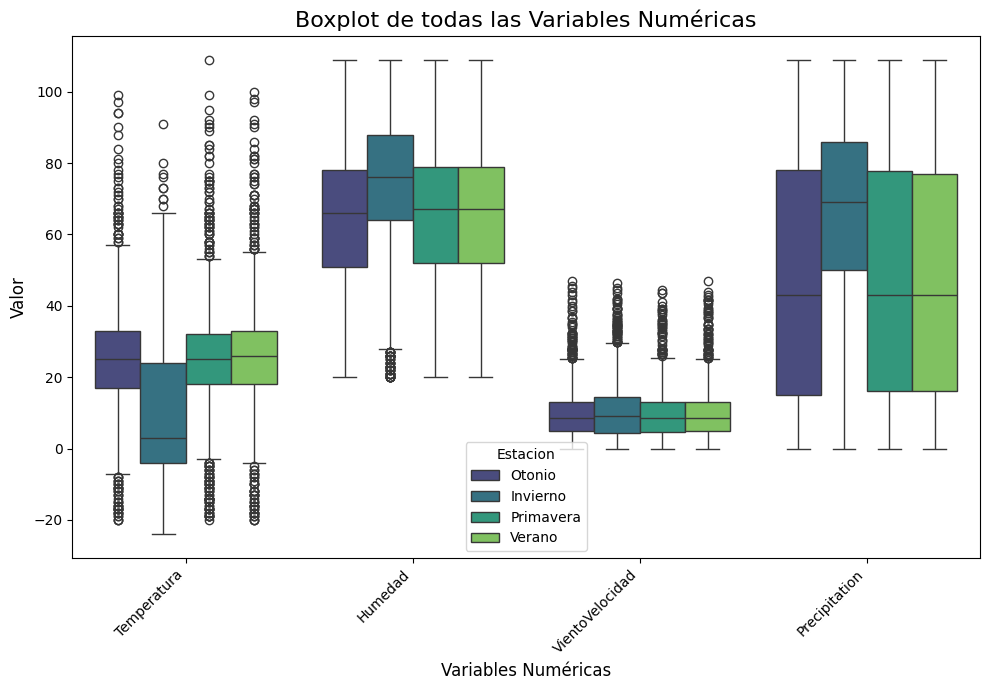

In [209]:
# Crear DataFrame combinado
df_bx = pd.concat([Xtrn[numerical_cols], ytrn.rename('Estacion')], axis=1)

# Pasar a formato largo
df_melted = df_bx.melt(id_vars='Estacion', var_name='Variable', value_name='Valor')

# Graficar boxplot
plt.figure(figsize=(10, 7))
sns.boxplot(data=df_melted, x='Variable', y='Valor', hue='Estacion', palette='viridis')

plt.title('Boxplot de todas las Variables Numéricas', fontsize=16)
plt.ylabel('Valor', fontsize=12)
plt.xlabel('Variables Numéricas', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


En el gráfico anterior se pueden ver boxplots de cada una de las variables numéricas ordenadas por estación. De esta manera se asegura descubrir valores atípicos teniendo en cuenta la distribución de la variable según las estación del año. 

Las variables de precipitación no tiene outliers en ninguna de las estaciones. Por otro lado, viento velocidad cuenta con una cantidad similar de atípicos y la distribución de la variable es muy similar para todas las estaciones. 

En el caso de la humedad, la distribución de la estación de invierno abarca valores más altos, contando con algunos outliers por debajo de su cola inferior y ninguno por encima de su cola superior. 

La anomalía mas grande observable en este gráfico está en la distribución de temperatura. Hay temperaturas registradas imposibles por encima y también muy cercanas a los 100 grados centígrados. Las colas superiores de todos los gráficos de caja se estiran superando temperaturas de 45 grados. Esto tiene como consecuencia que valores extremadamente inusuales como una temperatura de 60 grados en invierno no sea considerado como un outlier. Se puede concluir por lo tanto que los valores de temperatura tienen graves errores de incersión, por lo que habrá que realizar una limitación acorde, con el fin de eliminar del dataset los valores mal cargados que puedan introducir mucho ruido a las predicciones del modelo. 

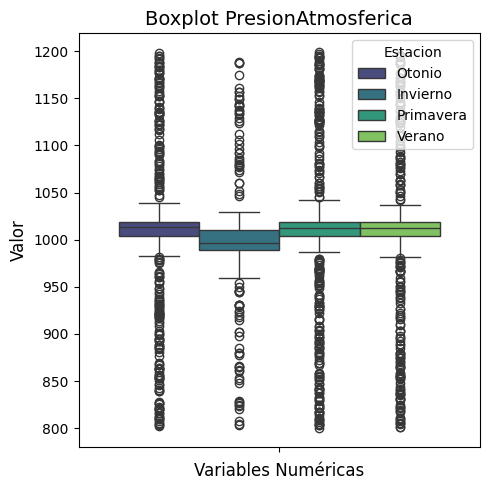

In [210]:
df_bx2 = pd.concat([Xtrn['PresionAtmosferica'], ytrn.rename('Estacion')], axis=1)

plt.figure(figsize=(5, 5))
sns.boxplot(data=df_bx2, y='PresionAtmosferica', palette='viridis', hue='Estacion')
plt.title('Boxplot PresionAtmosferica', fontsize=14)
plt.ylabel('Valor', fontsize=12)
plt.xlabel('Variables Numéricas', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

La distribución de la variable de presión atmosférica cuenta con una gran similitud nuevamente. La cantidad de outliers para cada estación es grande.

A continuación se realizan las limitaciones de los valores de temperatura en base al análisis realizado anteriormente. Para el invierno, la temperatura máxima posible será 30, un valor altamente improbable pero no imposible. Por otro lado, para todas las demás variables la temperatura máxima será 45 grados, la cuál es posible dependiendo de la parte del mundo en la que se realice la medición, aunque sigue siendo improbable, al igual que valores que sobrepasen ese límite. 

In [211]:
# Máscara de valores atípicos (se arma sobre el DF original)
limite_temp_inv = (df['Estacion'] == 'Invierno') & (df['Temperatura'] > 30)

# Queremos quedarnos solo con los NO-atípicos
mask_valid = ~limite_temp_inv

# Filtrar train
Xtrn = Xtrn.loc[mask_valid].reset_index(drop=True)
ytrn = ytrn.loc[mask_valid].reset_index(drop=True)

# Filtrar test
Xtst = Xtst.loc[mask_valid].reset_index(drop=True)
ytst = ytst.loc[mask_valid].reset_index(drop=True)


In [212]:
# Máscara de valores atípicos (se arma sobre el DF original)
limite_temp= (df['Temperatura'] > 45)

# Queremos quedarnos solo con los NO-atípicos
mask_valid2 = ~limite_temp

# Filtrar train
Xtrn = Xtrn.loc[mask_valid2].reset_index(drop=True)
ytrn = ytrn.loc[mask_valid2].reset_index(drop=True)

# Filtrar test
Xtst = Xtst.loc[mask_valid2].reset_index(drop=True)
ytst = ytst.loc[mask_valid2].reset_index(drop=True)

Con el siguiente código se eliminan los valores atípicos restantes en el dataset luego de las limitaciones establecidas. 

In [213]:
# Se usa winsorizer para cappear los outliers vistos en las distribuciones del grafico anterior
capper = Winsorizer(capping_method='iqr',
                    tail='both',
                    fold=1.5,
                    variables=['Temperatura', 'VientoVelocidad', 'PresionAtmosferica'])

capper.fit(Xtrn)
# Transformamos los datos
Xtrn = capper.transform(Xtrn)
Xtst = capper.transform(Xtst)

In [214]:
# Escalado de variables
scaler = StandardScaler()
Xtrn_scaled = pd.DataFrame(scaler.fit_transform(X=Xtrn[num_cols]),columns=Xtrn[num_cols].columns,index=Xtrn.index)
Xtst_scaled = pd.DataFrame(scaler.transform(X=Xtst[num_cols]),columns=Xtst[num_cols].columns,index=Xtst.index)

In [215]:
# Codificación de variables categóricas
ohe_cols = ['Localizacion_Costa', 'Localizacion_Llanura', 'Localizacion_Montania',
            'TipoClima_Lluvioso', 'TipoClima_Nevado', 'TipoClima_Nublado',
            'TipoClima_Soleado']

Xtrn_final = pd.concat([Xtrn_scaled, Xtrn[ohe_cols]], axis=1)

Xtst_final = pd.concat([Xtst_scaled, Xtst[ohe_cols]], axis=1)

# SVM 

## Kernel Lineal

Se realiza la optimización del hiperparámetro c mediante Grid search, considerando una amplia gama de valores para el mismo que van desde 10 hasta 1000 dando saltos de 10. De esta manera se asegura probar el modelo con márgenes tanto blandos como duros, analizando en cada caso que devuelve el mejor resultado.

In [ ]:
params_grid = {
    'C': range(10,1001,10)
}


svm_model = GridSearchCV(
    LinearSVC(max_iter=5000,random_state=42), 
    params_grid, 
    cv=5,
    scoring='accuracy',
    
)

svm_model.fit(Xtrn_final, ytrn)
print(f"Mejores parámetros encontrados: {svm_model.best_params_}")

Mejores parámetros encontrados: {'C': 10}


El mejor valor encontrado de C por la búsqueda exhaustiva de parámetros fue el menor valor posible testeado(10), lo que indica que fijar un margen blando para el problema a resolver ha sido la decisión más óptima para maximizar la accuracy del modelo. 

In [217]:
best_svm_linear = SVC(random_state=42,**svm_model.best_params_)

In [218]:
def obtener_scores_detalle(modelo, X, y, cv=5):
    """
    Aplica validación cruzada multiclase y devuelve arrays de scores.
    """
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted', 
        'recall': 'recall_weighted'        
    }
    
    results = cross_validate(modelo, X, y, cv=cv, scoring=scoring)
    
    scores_limpios = {
        'Accuracy': results['test_accuracy'],
        'Precision': results['test_precision'],
        'Recall': results['test_recall']
    }
    
    return scores_limpios

In [219]:
obtener_scores_detalle(best_svm_linear,X,y)

{'Accuracy': array([0.37215064, 0.38206145, 0.37611497, 0.38007929, 0.36818632]),
 'Precision': array([0.22842632, 0.22908433, 0.22757366, 0.22886073, 0.22295154]),
 'Recall': array([0.37215064, 0.38206145, 0.37611497, 0.38007929, 0.36818632])}

Todas las métricas obtenidas con SVM lineal son subóptimas, puesto que ninguna llega a romper la barrera del 0.45. Los resultados mantienen consistencia en los diferentes conjuntos de validación, por lo que no pareciera que se detecten indicios de sobreajuste. 

Esto puede indicar que existen relaciones no lineales entre variables que un modelo lineal de SVM no será capaz de interpretar. 

En el siguiente apartado se implementa y se analiza una solución no lineal para el problema. 

## Kernel Gaussiano

Para la optimización del clasificador SVM con kernel Gaussiano se realizó una búsqueda aleatoria sobre un conjunto de hiperparámetros seleccionados por su relevancia y su impacto directo en la capacidad del modelo para ajustarse a datos no lineales. Se evaluaron distintos valores de **C** ([1, 10, 100, 1000]) con el objetivo de explorar desde modelos más simples y regularizados hasta modelos más flexibles capaces de adaptarse mejor a patrones complejos. Asimismo, se probaron diferentes valores de **gamma** ([1e-2, 1e-3, 1e-4]), ya que este parámetro controla la influencia local de cada punto y determina la suavidad de la frontera de decisión en el espacio transformado. Estos rangos permiten evaluar configuraciones que van desde fronteras de decisión amplias y suaves hasta fronteras muy ajustadas, logrando así identificar la combinación óptima para el desempeño del modelo.

In [220]:
params_grid_gaussian = {
    'C': [1,10,100,1000],
    'gamma': [1e-2,1e-3, 1e-4,],
    'kernel': ['rbf']
}


svm_model_gaussian = RandomizedSearchCV(
    SVC(random_state=42), 
    params_grid_gaussian, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

svm_model_gaussian.fit(Xtrn_final, ytrn)
print(f"Mejores parámetros encontrados: {svm_model_gaussian.best_params_}")


Mejores parámetros encontrados: {'kernel': 'rbf', 'gamma': 0.001, 'C': 1}


El proceso de búsqueda seleccionó los hiperparámetros C = 1 y gamma = 0.001, lo que indica que el modelo obtuvo su mejor desempeño con una regularización moderada y una frontera de decisión relativamente suave.

In [221]:
best_svm_gaussian = SVC(random_state=42,**svm_model_gaussian.best_params_)

In [222]:
obtener_scores_detalle(best_svm_gaussian,X,y)

{'Accuracy': array([0.38899901, 0.38800793, 0.38751239, 0.38007929, 0.37611497]),
 'Precision': array([0.46549056, 0.45409897, 0.45204732, 0.45052519, 0.45607272]),
 'Recall': array([0.38899901, 0.38800793, 0.38751239, 0.38007929, 0.37611497])}

Las métricas obtenidas mediante validación cruzada muestran un desempeño consistente pero bajo: la accuracy ronda el 0.38, y tanto la precisión como el recall se mantienen alrededor de 0.45 y 0.38 respectivamente, con variaciones mínimas entre las particiones. Esto sugiere que el modelo es estable pero tiene dificultades para capturar patrones discriminativos en los datos.

Ninguno de los modelos de SVM ha logrado un resultado deseable, por lo que se descarta que el bajo desempeño se pueda atribuir a la no linealidad de la primera solución planteada. 

# Random Forest

In [223]:
params_grid_rf = {
    'n_estimators': range(10, 301, 10), 
    'max_depth': [10, 20, 30, 40, None] 
}


rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions=params_grid_rf,                        
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42 
)

print("Iniciando optimización para Random Forest...")
rf_search.fit(Xtrn_final, ytrn)


print("¡Optimización terminada!")
print(f"Mejores parámetros encontrados: {rf_search.best_params_}")

Iniciando optimización para Random Forest...
¡Optimización terminada!
Mejores parámetros encontrados: {'n_estimators': 140, 'max_depth': 30}


En el proceso de optimización del modelo Random Forest se exploraron valores de n_estimators entre 10 y 300 para evaluar cómo afecta la cantidad de árboles tanto la estabilidad como la capacidad de generalización del ensamble. Asimismo, se analizaron distintos valores para max_depth (10, 20, 30, 40 y sin límite) con el fin de controlar la profundidad de los árboles y evitar sobreajuste en estructuras excesivamente complejas. La búsqueda identificó como óptimos los parámetros n_estimators = 140 y max_depth = 30, lo cual indica que el modelo necesita una cantidad intermedia de árboles y una profundidad moderada para capturar patrones relevantes sin caer en una complejidad excesiva.

In [224]:
best_rf_model = RandomForestClassifier(random_state=42,**rf_search.best_params_)

In [225]:
obtener_scores_detalle(best_rf_model,X,y)

{'Accuracy': array([0.37264618, 0.3741328 , 0.37710605, 0.38007929, 0.37363726]),
 'Precision': array([0.42747018, 0.41775316, 0.42570985, 0.4194032 , 0.42553645]),
 'Recall': array([0.37264618, 0.3741328 , 0.37710605, 0.38007929, 0.37363726])}

Al igual que con los modelos implementados anteriormente, las métricas obtenidas mediante validación cruzada muestran que el Random Forest optimizado alcanza un desempeño bajo y relativamente estable en todas las particiones. La **accuracy** se mantiene alrededor de 0.37, mientras que la **precisión** ronda valores cercanos a 0.42 y el **recall** se estabiliza en torno a 0.37, con variaciones mínimas entre folds. 
